In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv('../input/sejong-ai-challenge-p1/train.csv')
test=pd.read_csv('../input/sejong-ai-challenge-p1/test.csv')
submit=pd.read_csv('../input/sejong-ai-challenge-p1/sample_submission.csv')

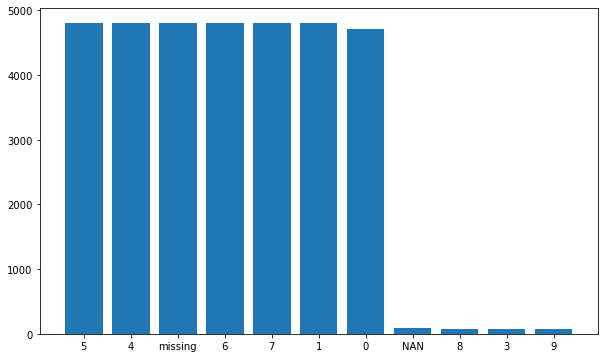

In [3]:
# 데이터 불균형
# 이상 label 발견. label의 object화. 즉, 숫자로 바꿔준다. 

temp=train['label'].value_counts()

fig,ax=plt.subplots(1,1,figsize=(10,6))

ax.bar(temp.index,temp)

plt.show()

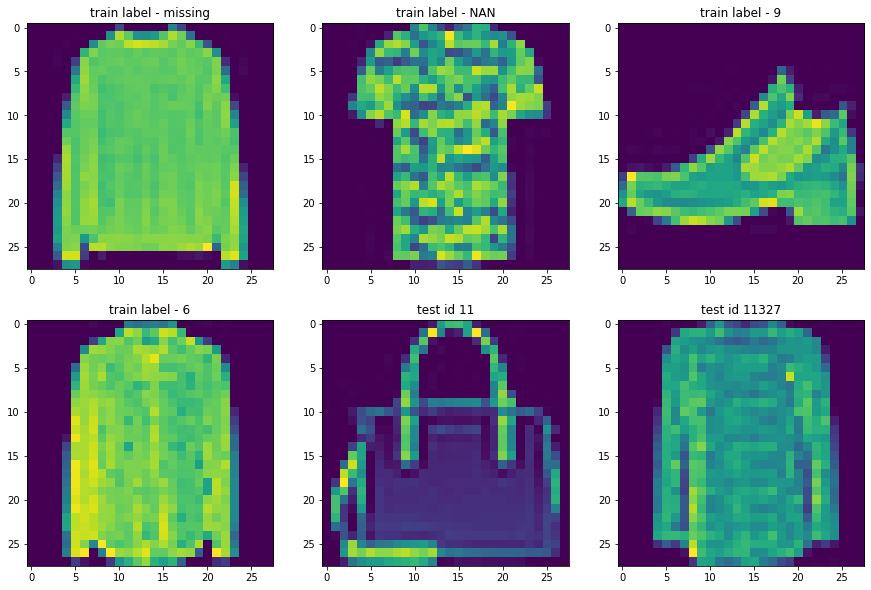

In [4]:
# 처음 데이터에서 to_numpy함수때문인지 PIL 라이브러리인지 잘못사용하여 object형태로 됐다. 
# 숫자로 다시 표시

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[33838][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - missing')

ax[0,1].imshow(train.iloc[3][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - NAN')

ax[0,2].imshow(train.iloc[1][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - 9')

ax[1,0].imshow(train.iloc[2][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - 6')

ax[1,1].imshow(test.iloc[0][1:].values.astype(int).reshape(28,28))
ax[1,1].set_title('test id 11')

ax[1,2].imshow(test.iloc[1613][1:].values.astype(int).reshape(28,28))
ax[1,2].set_title('test id 11327')

plt.show()

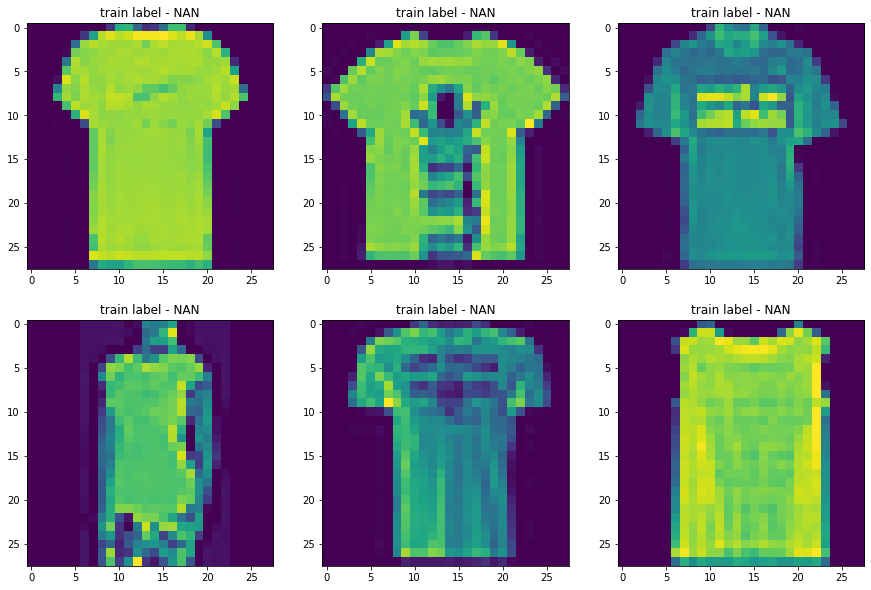

In [5]:
# train[train['label']=='NAN']

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[10][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - NAN')

ax[0,1].imshow(train.iloc[12][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - NAN')

ax[0,2].imshow(train.iloc[34][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - NAN')

ax[1,0].imshow(train.iloc[66][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - NAN')

ax[1,1].imshow(train.iloc[724][1:-1].values.astype(int).reshape(28,28))
ax[1,1].set_title('train label - NAN')

ax[1,2].imshow(train.iloc[730][1:-1].values.astype(int).reshape(28,28))
ax[1,2].set_title('train label - NAN')

plt.show()

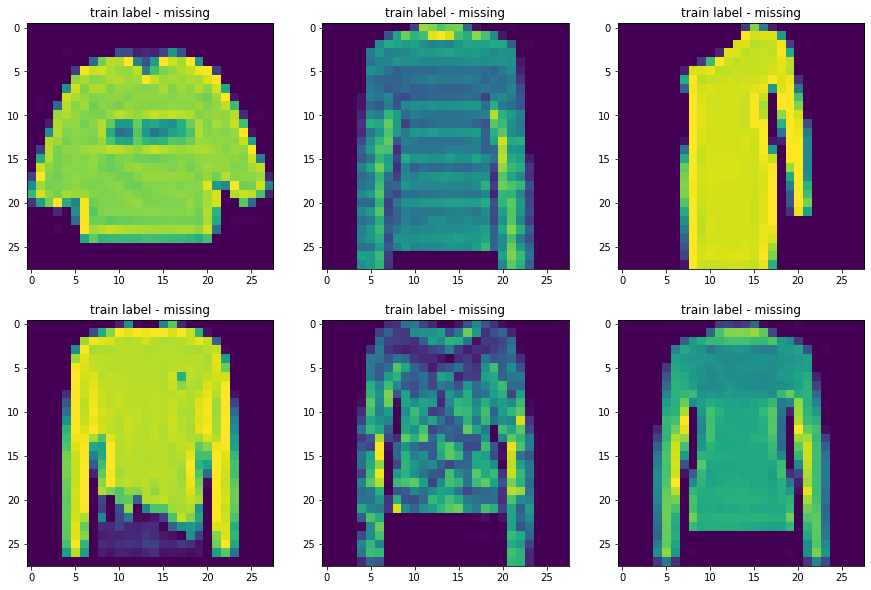

In [6]:
# train[train['label']=='missing']

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[0][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - missing')

ax[0,1].imshow(train.iloc[13][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - missing')

ax[0,2].imshow(train.iloc[27][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - missing')

ax[1,0].imshow(train.iloc[30][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - missing')

ax[1,1].imshow(train.iloc[39][1:-1].values.astype(int).reshape(28,28))
ax[1,1].set_title('train label - missing')

ax[1,2].imshow(train.iloc[33802][1:-1].values.astype(int).reshape(28,28))
ax[1,2].set_title('train label - missing')

plt.show()

의미가 없다. missing과 nan은 몇몇개 섞여있어서 그 자체로 인정해준다. 

label 처리

In [7]:
train['label']=train['label'].apply(lambda x:'2' if x=='missing' else x)
train['label']=train['label'].apply(lambda x:'10' if x=='NAN' else x)

In [8]:
y=train['label'].astype(int).values
X=train.drop(['id','label'],axis=1).values

In [9]:
X_test=test.drop('id',axis=1).values

DNN

In [10]:
from sklearn.model_selection import train_test_split

X_tr,X_val,y_tr,y_val=train_test_split(X,y,random_state=71,stratify=y,test_size=0.2)

In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset

In [12]:
trainDataset=TensorDataset(torch.from_numpy(X_tr).float(),torch.from_numpy(y_tr).long())
validDataset=TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(y_val).long())

In [13]:
trainLoader=DataLoader(dataset=trainDataset,batch_size=64,shuffle=True)
validLoader=DataLoader(dataset=validDataset,batch_size=64,shuffle=True)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=nn.Linear(784,460)
        self.fc2=nn.Linear(460,230)
        self.fc3=nn.Linear(230,110)
        self.fc4=nn.Linear(110,11)
        self.relu=nn.ReLU()
        self.bn1=nn.BatchNorm1d(460)
        self.bn2=nn.BatchNorm1d(230)
        self.bn3=nn.BatchNorm1d(110)
        self.drop=nn.Dropout(p=0.2)
    
    def forward(self,output):
        output=self.fc1(output)
        output=self.bn1(output)
        output=self.drop(output)
        output=self.relu(output)
        output=self.fc2(output)
        output=self.bn2(output)
        output=self.drop(output)
        output=self.relu(output)
        output=self.fc3(output)
        output=self.bn3(output)
        output=self.drop(output)
        output=self.relu(output)
        output=self.fc4(output)
        return output

In [15]:
model=Net()

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=3e-3)

# cpu로만.
device=torch.device('gpu' if torch.cuda.is_available() else 'cpu')

In [16]:
loss_list=[]
accuracy_list=[]
iteration_list=[]

iter_num=0

model.train()
for epoch in range(5):
    for i,(x_tr,y_tr) in enumerate(trainLoader):
      
        output=model(x_tr)
        
        loss=criterion(output,y_tr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter_num+=1
        
        if (i+1)%50==0:
            correct=0
            total=0
            for x_val,y_val in validLoader:
                
                output=model(x_val)
            
                pred=torch.max(output,dim=1)[1]
                
                total+=y_val.size(0)
                
                correct+=(pred==y_val).sum()
            
            accuracy=100*(correct/total)
            loss_list.append(loss.data)
            iteration_list.append(iter_num)
            accuracy_list.append(accuracy)

        if (iter_num+1)%1000==0:
            print(f'Iteration: {iter_num+1} Loss: {loss.data:0.4f} Val Accuracy: {accuracy:0.4f}')

Iteration: 1000 Loss: 0.6905 Val Accuracy: 78.9598
Iteration: 2000 Loss: 0.4873 Val Accuracy: 81.3830


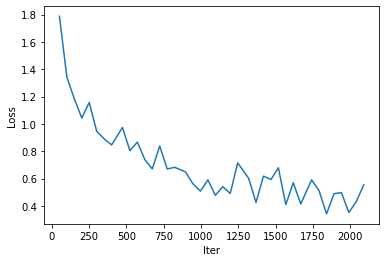

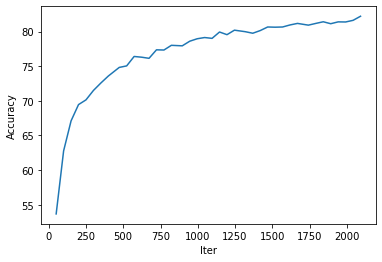

In [17]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.show()

plt.plot(iteration_list,accuracy_list)
plt.xlabel("Iter")
plt.ylabel("Accuracy")
plt.show()

In [18]:
model.eval()

with torch.no_grad():
    x_test=torch.from_numpy(X_test).float()
    output=model(x_test)
    pred=torch.max(output,1)[1]

In [19]:
submit['label']=pred.numpy()
submit.head()

,id,label
0,11,5
1,15,6
2,17,4
3,21,7
4,22,4


In [20]:
# 실험일지

# 1. dropout 0.2 넣었을 때 감소 근데 안정적이다. 그래서 epoch를 늘려보기로 했다. 5->15
# 2. 올라가는 정도가 약하다. benchmark에 딸린다. dropout 제거 후 normalization만.
# 3. normalization dropout보단 낫다. 어울리는 문제들이 있는것 같다. 이건 아니다. 
# 4. 같이 썼는데 그저 그렇다. benchmark보다 안나온다. 

# 결론 
# 위 문제에서의 dnn은 단순 dnn이 낫다. 

# 참고
# 저자가 말하는 순서는 fc -> bn -> drop -> activation -> fc 순이다.

In [21]:
# submit.to_csv('submit_dnn+dropout0.2_20210325.csv',index=False)